In [2]:
import os
import sys
from importlib import reload
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)
        
from time import time 
import csv
import pickle

import numpy as np
import pandas as pd

import gb1
import utils

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
plt.rcParams["font.size"] = 14

import seaborn as sns
sns.set_style('white')

MODEL_PATH = '/data/wongfanc/gb1-models/'

2025-01-24 22:08:16.844128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-24 22:08:16.844159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-24 22:08:16.845227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 22:08:16.851925: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-24 22:08:18.678089: W tensorflow/comp

In [3]:
# load design distributions from both 5k- and 10k-trained models
temperatures = np.arange(0.2, 0.701, 0.005)
exceedance_threshold = 1.1

# design distributions from 10k-trained model
imptemp2theta = {
    round(temp, 4): np.load(MODEL_PATH + 'gb1-h10-10k-t{:.4f}-051324.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
# load true exceedances
with open('/data/wongfanc/gb1-models/h10-10k-051324-temp2exceed{}.pkl'.format(exceedance_threshold), 'rb') as f:
    imptemp2exceed = pickle.load(f)

# design distributions from 5k-trained model
pptemp2theta = {
    round(temp, 4): np.load(MODEL_PATH + 'gb1-h10-5k-t{:.4f}-030123.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
# load true exceedances from *5k-030123* distributions
with open('/data/wongfanc/gb1-models/h10-5k-030123-temp2exceed{}.pkl'.format(exceedance_threshold), 'rb') as f:
    pptemp2exceed = pickle.load(f)
    

In [4]:
# load PP selection results (computed in gb1-5k-exceedance-121824.ipynb)
reload(utils)
target_values = np.arange(0.0, 1.01, 0.02)
n_pp_trial = 500
pp_results_csv_fname = '/data/wongfanc/gb1-results/gb1-pp-exceed{:.4f}-012225.csv'.format(exceedance_threshold)
mc_csv_fname = '/data/wongfanc/gb1-results/gb1-qc-exceed{:.4f}-012225.csv'.format(exceedance_threshold)


pp_df = pd.read_csv(pp_results_csv_fname, index_col=0)
ppworst_v, pperr_v, ppdisc_v, ppval2temprange = utils.process_gb1_selection_experiments(
    pp_df, target_values, temperatures, pptemp2exceed, n_pp_trial, imp_or_pp='pp'
)

mc_df = pd.read_csv(mc_csv_fname, index_col=0)
mcworst_v, mcerr_v, mcdisc_v = utils.process_gb1_cp_selection_experiments(
    mc_df, target_values, temperatures, pptemp2exceed, n_pp_trial
)

Processing pp results with 101 temperatures in [0.200, 0.700], 51 target values in [0.00, 1.00], 500 trials, and alpha = 0.1
Done processing (56 s)


In [5]:
# load imputation selection results (computed in gb1-10k-exceedance-011425.ipynb)
reload(utils)
n_imp_trial = 10
imp_results_csv_fname = '/data/wongfanc/gb1-results/gb1-imp-exceed{:.4f}-011425.csv'.format(exceedance_threshold)
gmm_csv_fname = '/data/wongfanc/gb1-results/gb1-gmm-exceed{:.4f}-011425.csv'.format(exceedance_threshold)
gmm_forecast_qs = [0, 0.5, 1]

# process imputation selection results for plotting
imp_df = pd.read_csv(imp_results_csv_fname, index_col=0)
impworst_v, imperr_v, impdisc_v, impval2temprange = utils.process_gb1_selection_experiments(
    imp_df, target_values, temperatures, imptemp2exceed, n_imp_trial, imp_or_pp='imp'
)

# process GMM forecast selection results for plotting
gmm_temp_names = ['temp{:.4f}'.format(round(temp, 4)) for temp in temperatures]
gmm_name2trueexceed = {'temp{:.4f}'.format(round(temp, 4)): imptemp2exceed[round(temp, 4)] for temp in temperatures}
gmm_df = pd.read_csv(gmm_csv_fname, index_col=0)
gmm_type2results = utils.process_wheelock_selection_experiments(
    gmm_df, target_values, gmm_temp_names, gmm_name2trueexceed, n_imp_trial, qs=gmm_forecast_qs
)


Processing imp results with 101 temperatures in [0.200, 0.700], 51 target values in [0.00, 1.00], 10 trials, and alpha = 0.1
Done processing (1 s)


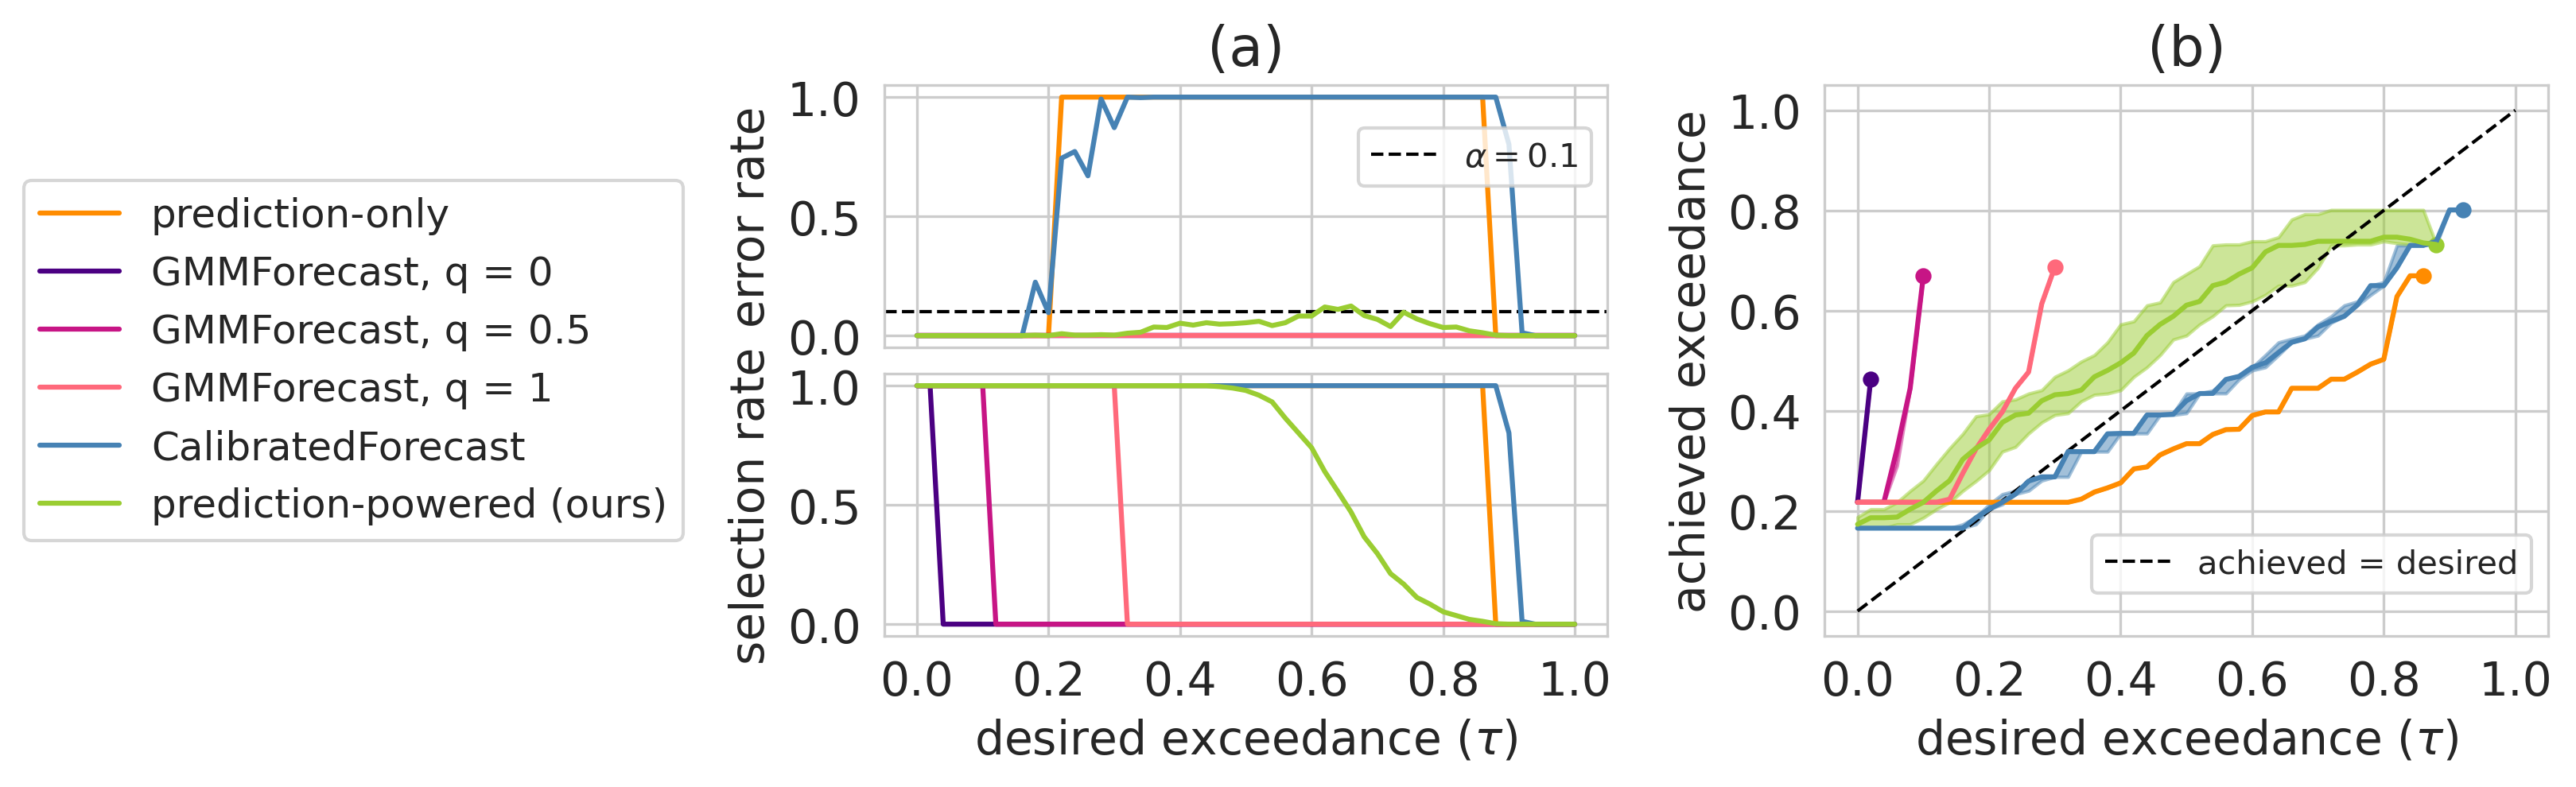

In [6]:
# one-row figure
sns.set_style('whitegrid')
fig = plt.figure(figsize=(9, 3), dpi=300)

gs = gridspec.GridSpec(1, 2, figure=fig)
gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0])

ax1 = fig.add_subplot(gs[1])
ax00 = fig.add_subplot(gs0[0])
ax10 = fig.add_subplot(gs0[1])

fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.1)


alpha = 0.1
gmm_type = 'cs'
imp_color = 'darkorange'
pp_color = 'yellowgreen'
gmm_colors = ['indigo', 'mediumvioletred', '#ff697b']
dark_line_color = 'k'

lw = 1.5
legend_fs = 12
xlim = [-0.05, 1.05]
xticks = np.arange(0, 1.01, 0.2)
yticks = np.arange(0, 1.01, 0.5)
marker_sz = 15

q_low = 0.2
q_high = 0.8


# ===== subplot (a) =====

# ----- top (error) -----
ax00.axhline(alpha, linestyle='--', color=dark_line_color, alpha=1, linewidth=1, label=r'$\alpha = {}$'.format(alpha));

ax00.plot(target_values, imperr_v, c=imp_color, linewidth=lw);
for q_idx, q in enumerate(gmm_forecast_qs):
    _, gmmerr_v, gmmdisc_v, _ = gmm_type2results[gmm_type][q]
    ax00.plot(target_values, gmmerr_v, c=gmm_colors[q_idx], linewidth=lw);
ax00.plot(target_values, mcerr_v, c='steelblue', linewidth=lw);
ax00.plot(target_values, pperr_v, c=pp_color, linewidth=lw);

ax00.set_yticks(yticks)
ax00.set_xlim(xlim)
ax00.set_ylim(xlim)
ax00.set_xticks(xticks)
ax00.set_xticklabels([])
ax00.set_ylabel('error rate');
ax00.set_title('(a)');

ax00.legend(fontsize=10, loc='upper right', bbox_to_anchor=(1, 0.9));


# ----- bottom (selection rate) -----

ax10.plot(target_values, impdisc_v, '-', c=imp_color, linewidth=lw);
for q_idx, q in enumerate(gmm_forecast_qs):
    _, gmmerr_v, gmmdisc_v, _ = gmm_type2results[gmm_type][q]
    ax10.plot(target_values, gmmdisc_v, '-', c=gmm_colors[q_idx], linewidth=lw);
ax10.plot(target_values, mcdisc_v, '-', c='steelblue', linewidth=lw);
ax10.plot(target_values, ppdisc_v, '-', c=pp_color, linewidth=lw);

# dummy so get legend for (b)
ax10.plot([-1, -1], [-1, -1], '--', c=dark_line_color, linewidth=1, label='achieved = desired')
ax10.legend(fontsize=10, loc='upper right', bbox_to_anchor=(2.3, 0.45));

ax10.set_xlim(xlim)
ax10.set_ylim(xlim)
ax10.set_xticks(xticks)
ax10.set_yticks(yticks)
ax10.set_ylabel('selection rate');
ax10.set_xlabel(r'desired exceedance ($\tau$)');



# # ===== subplot (b) =====

ax1.plot([0, 1], [0, 1], '--', c=dark_line_color, alpha=1, linewidth=1);
median_v = [np.median(worst) if len(worst) else np.nan for worst in impworst_v]
ax1.plot(
    target_values, median_v,
    c=imp_color, label='prediction-only', linewidth=lw,
)
last_idx = np.where(np.isnan(median_v))[0][0] - 1
ax1.scatter(target_values[last_idx], median_v[last_idx], c=imp_color, s=marker_sz, alpha=1)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)

for q_idx, q in enumerate(gmm_forecast_qs):
    gmmworst_v, _, _, _ = gmm_type2results[gmm_type][q]
    median_v = [np.median(worst) if len(worst) else np.nan for worst in gmmworst_v]
    ax1.plot(
        target_values, median_v,
        c=gmm_colors[q_idx], label=f'GMMForecast, q = {q}', linewidth=lw,
    )
    last_idx = np.where(np.isnan(median_v))[0][0] - 1
    ax1.scatter(target_values[last_idx], median_v[last_idx], c=gmm_colors[q_idx], s=marker_sz, alpha=1)
    ax1.fill_between(
        target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in gmmworst_v],
        [np.quantile(worst, q_high) if len(worst) else np.nan for worst in gmmworst_v],
        color=gmm_colors[q_idx], alpha=0.5,
    )


median_v = [np.median(worst) if len(worst) else np.nan for worst in mcworst_v]
ax1.plot(
    target_values, median_v,
    c='steelblue', label='CalibratedForecast', linewidth=lw,
)
last_idx = np.where(np.isnan(median_v))[0][0] - 1
ax1.scatter(target_values[last_idx], median_v[last_idx], c='steelblue', s=marker_sz, alpha=1)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in mcworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in mcworst_v],
    color='steelblue', alpha=0.5,
)

median_v = [np.median(worst) if len(worst) else np.nan for worst in ppworst_v]
ax1.plot(
    target_values, median_v,
    c=pp_color, label='prediction-powered (ours)', linewidth=lw,
)
last_idx = np.where(np.isnan(median_v))[0][0] - 1
ax1.scatter(target_values[last_idx], median_v[last_idx], c=pp_color, s=marker_sz, alpha=1)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)

ax1.set_xlim(xlim)
ax1.set_ylim(xlim)
ax1.set_xticks(xticks)
ax1.set_yticks(xticks)
ax1.legend(fontsize=legend_fs, loc='center right', bbox_to_anchor=(-1.55, 0.5))

ax1.set_title('(b)')
ax1.set_ylabel('achieved exceedance');
ax1.set_xlabel(r'desired exceedance ($\tau$)');


In [7]:
# find percentiles of training labels
# load training sequences
fname = '/data/wongfanc/gb1-models/gb1-h10-5k-030123-train-idx.npz'
d = np.load(fname)
train_idx = d['train_idx'][: 5000]

df = pd.read_csv('../data/gb1-with-variance.csv')
seq_n = list(df['Variants'].str.lower())
y_n = df['log_fitness'].to_numpy()

trainseq_n = [seq_n[i] for i in train_idx]
ytrain_n = np.array([y_n[i] for i in train_idx])

In [8]:
np.mean(y_n >= 1.)

0.0061